In [1]:
import matplotlib
import numpy as np
import pandas as pd
import psycopg2 as pg
%matplotlib inline

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

In [ ]:
from dateutil.relativedelta import relativedelta

In [3]:
# If you want Jupyter to print all returned output for a cell, and not just the last returned output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def get_postgres_connection(pass_file):
    """ Takes a database credential file (see default_profile.example) and return a connection to the database.
    
    :param string pass_file: path to file where database credentials are stored. 
                             Format of file is PGHOST=... PGUSER=... etc as in the example profile
    :return: a connection to the Postgres database whose credentials are given in the provided file
    :rtype: psycopg2.connection
    """
    f = open(pass_file, 'r')
    with open(pass_file, 'r') as f:
        passinfo = f.readlines()
    f.close()

    database_credentials = [line.strip().split("=")[1] for line in passinfo] # get whatever follows = sign
    #database_credentials # don't print this out in Jupyter notebook for world to see!
    host_address = database_credentials[0]
    user_name = database_credentials[1]
    name_of_database = database_credentials[2]
    user_password = database_credentials[3]
    conn = pg.connect(host=host_address, database=name_of_database, user=user_name, password=user_password)
    return conn

In [28]:
def get_all_table_names(conn, schema = "public"):
    """ Takes a postgres database connection and schema name and returns all tables and views available in the schema.
    
    :param psycopg2.connection conn: POSTGRESQL connection object to the desired database
    :param string schema: name of the schema to get the table names and view names from
    :return: a list of table and view names for the desired schema
    :rtype: list[string]
    """
    cursor = conn.cursor()
    sqlcmd_table_names = "SELECT table_name FROM information_schema.tables WHERE table_schema = \'%s\'" % (schema)
    cursor.execute(sqlcmd_table_names)
    table_names = cursor.fetchall()
    table_names = [i[0] for i in table_names]
    return(table_names)

In [29]:
# Read in database credentials from file to postgres connection
# List all tables available in default schema
pass_file = "/mnt/data/mvesc/PartnerData/default_profile"
conn = get_postgres_connection(pass_file)
table_names = get_all_table_names(conn)

In [33]:
print(table_names)

['DistrictSchoolIDs', 'all_lookup', 'CoshoctonGrades2006_16', 'Ridgewoodgrades2007_2016', 'WestMuskingumgrades2006_16', 'Franklingrades2006_16', 'MATVWMAbsences1415', 'CCFRRWRVabsence09_16', 'MATVWMAbsences1516', 'CurrentMobility', 'CurrentStudents', 'ASQ_Preschool', 'ActScores', 'AllDistricts1112', 'HSGrades', 'AllDistricts1213', 'AIRScores', 'AllDistricts1314', 'CurrentAbsenceDiscipline', 'DIBELSv2', 'AllDistricts1415', 'AllGradsTotal', 'OAAOGT', 'PARCC', 'StarRead', 'StarEL', 'StarMath', 'TerraNova', 'Maysvillegrades2006_16']


In [9]:
def read_table_to_df(table_name, connection):
    """ Takes a table name as input and returns postgres table as pandas data frame.
    
    :param string table_name: Name of table to read in
    :param psycopg2.connection connection: POSTGRESQL connection object for Python
    :return: a Pandas dataframe object containing the desired table
    :rtype: Pandas.dataframe
    """
    sql_query = "SELECT * FROM \"" + table_name + "\";"
    data = pd.read_sql(sql_query, connection)
    return data

In [10]:
# What range of years do we have data for?
YEAR_RANGE = range(11, 16)
FULL_YEAR_RANGE = [2000 + i for i in YEAR_RANGE]

In [11]:
# List of table names for all yearly student snapshots
ALL_DISTRICTS_TABLES = ["AllDistricts" + str(num) + str(num+1) for num in YEAR_RANGE[0:-1]]
ALL_DISTRICTS_TABLES.append("CurrentStudents")
ALL_DISTRICTS_TABLES

['AllDistricts1112',
 'AllDistricts1213',
 'AllDistricts1314',
 'AllDistricts1415',
 'CurrentStudents']

In [12]:
# Get AllGradsTotal, CurrentMobility, and CurrentAbsenceDiscipline tables from database to dataframes
all_grads = read_table_to_df("AllGradsTotal", conn)
current_mobility = read_table_to_df("CurrentMobility", conn)
current_absence_discipline = read_table_to_df("CurrentAbsenceDiscipline", conn)

In [13]:
all_districts_data = [read_table_to_df(table_name, conn) for table_name in ALL_DISTRICTS_TABLES]
ALL_DISTRICTS_TABLES[-1] = "AllDistricts1516" # rename CurrentStudents to conform to naming standards

In [14]:
# However, for the all_districts_data, how are we going to handle the null lookup numbers? 
# Let's duplicate the dataframes and drop the null lookups for now, hopefully they won't be null for long
# Let's also set StudentLookup column as the Pandas row index
all_districts_copied = [None] * len(all_districts_data)
for i, df in enumerate(all_districts_data):
    df2 = df[pd.notnull(df.StudentLookup)]
    all_districts_copied[i] = df2.set_index("StudentLookup")
all_grads.set_index("StudentLookup", inplace = True)

In [15]:
dict_all_districts = {k:v for (k,v) in zip(ALL_DISTRICTS_TABLES, all_districts_copied)}
dict_all_districts.keys()

dict_keys(['AllDistricts1112', 'AllDistricts1213', 'AllDistricts1415', 'AllDistricts1516', 'AllDistricts1314'])

In [16]:
def get_unique_stripped_sorted_values(sort_column, coding, 
                                      code_column = "Disadvantaged", data = all_grads):
    """Subsets a dataframe by rows containing particular value in the code column, and then strips and 
       sorts all unique values in sort column of the matching rows. Returns these unique sorted values 
       in a list. Useful if we want to find, for example, which districts used a particular code or value.
       
    :param string sort_column: Name of the column to find unique values of (for matching rows)
    :param string coding: Value of the code to subset the data by
    :param string code_column: Column to find the code to subset the data by
    :param Pandas.dataframe data: input dataframe
    :return: a list containing unique values in specified column for the matching rows
    :rtype: list[dtype of sort_column] 
    """
    unique_values_for_code = data[sort_column][data[code_column] == coding].unique()
    unique_values_for_code_stripped = [d.strip() for d in unique_values_for_code]
    unique_values_for_code_stripped.sort()
    return(unique_values_for_code_stripped)

In [17]:
# There are two very similar looking codes for economic/academic disadvantage: 
# "1 - Economic disadvantagement" and "Economic Disadvantagement"
# Let's just check if the coding scheme has changed over time or varies district to district

districts_codetype1 = get_unique_stripped_sorted_values(sort_column = "DistrictCode", 
                                        coding = "1 - Economic disadvantagement")
districts_codetype2 = get_unique_stripped_sorted_values(sort_column = "DistrictCode", 
                                        coding = "Economic Disadvantagement")
print("1 - Economic disadvantagement: " + str(districts_codetype1))
print("Economic Disadvantagement: " + str(districts_codetype2))

grad_date_codetype1 = get_unique_stripped_sorted_values(sort_column = "HIGH_SCHOOL_GRAD_DATE",
                                        coding = "1 - Economic disadvantagement")
grad_date_codetype2 = get_unique_stripped_sorted_values(sort_column = "HIGH_SCHOOL_GRAD_DATE",
                                        coding = "Economic Disadvantagement")

print("%s: %s to %s" % ("1 - Economic disadvantagement", grad_date_codetype1[0], grad_date_codetype1[-1]))
print("%s: %s to %s" % ("Economic Disadvantagement", grad_date_codetype2[0], grad_date_codetype2[-1]))

1 - Economic disadvantagement: ['D13', 'D15', 'D5', 'D7', 'D8']
Economic Disadvantagement: ['D1', 'D10', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
1 - Economic disadvantagement: 20110114 to 20150630
Economic Disadvantagement: 20110516 to 20150701


How many students are not disadvantaged? Economic ? Academic ? It isn't clear why there are two coding types for each, or why there are so few academic disadvantaged students in the data -- but this is grads only.

In [18]:
all_grads_valuecounts = {colname: all_grads[colname].value_counts(dropna=False) for colname in all_grads.columns}
all_grads_valuecounts["Disadvantaged"]

                                          5488
Economic Disadvantagement                 3208
1 - Economic disadvantagement              475
Academic Disadvantagement                   19
Economic and Academic Disadvantagement       7
2 - Academic disadvantagement                1
Name: Disadvantaged, dtype: int64

In [19]:
all_grads['grad_date_formatted'] = pd.to_datetime(all_grads.HIGH_SCHOOL_GRAD_DATE, format = "%Y%m%d")
all_grads['grad_year'] = pd.Series([grad_date.year for grad_date in all_grads.grad_date_formatted], 
                                   index = all_grads.index)
all_grads.grad_year.value_counts(dropna=False)
all_grads.grad_year.unique().sort()

2015    2055
2013    1898
2011    1762
2012    1742
2014    1741
Name: grad_year, dtype: int64

In [20]:
def get_graduates_in_snapshots(grad_year, table_names, 
                               graduate_data = all_grads, district_tables = dict_all_districts):
    """Search for all high school graduates within a given calendar year. Returns list of student lookup numbers
       whose records can be found within a particular academic year snapshot table (or list of tables).
       
    :param int grad_year: Year to subset high school graduation date by 
    :param list[string] table_names: list of table names (see ALL_DISTRICTS_TABLES) in which to search for student 
                        yearly academic records
    :param Pandas.dataframe all_grads: dataframe containing all high school graduates including graduation date
    :param dict(list[string]: list[Pandas.dataframe]) district_tables: dict of dataframes containing yearly academic 
                        snapshots for all students in a particular academic year, referenced by table name
    :return: list of student lookup numbers that graduated in specified year and whose records found in specified table
    :rtype: Int64Index
    """
    district_tables_to_search = [district_tables[table] for table in table_names]
    grads_for_spec_year = graduate_data.index[graduate_data.grad_year == grad_year]
    
    # union the student lookups covered in all district tables given to get all students covered
    all_students = set()
    for student_year in district_tables_to_search:
        z = set(student_year.index)
        all_students = all_students.union(z)
    grads_in_district_tables = grads_for_spec_year[[graduate in all_students for graduate in grads_for_spec_year]]
    return(grads_in_district_tables)

In [22]:
# How many graduates do we have in our records for each year and how many of those can be found in the 
# year by year district lookup tables for at least one year?
# Also builds a dictionary with student lookup of valid grads by graduation year key

all_grads_in_tables = {}
for grad_year in FULL_YEAR_RANGE:
    total_grads = sum(all_grads.grad_year == grad_year)
    grads_in_tables = get_graduates_in_snapshots(grad_year, list(dict_all_districts.keys()))
    all_grads_in_tables[grad_year] = grads_in_tables
    
    print("total graduates in %d: %d\t num grads in district tables: %d" % 
          (grad_year, total_grads, len(grads_in_tables)))

total graduates in 2011: 1762	 num grads in district tables: 18
total graduates in 2012: 1742	 num grads in district tables: 1726
total graduates in 2013: 1898	 num grads in district tables: 1883
total graduates in 2014: 1741	 num grads in district tables: 1722
total graduates in 2015: 2055	 num grads in district tables: 2041


In [23]:
def get_student_field_from_districts(student_num, field_name, district_tables = all_districts_copied, 
                                     flag_if_diff = True):
    """Search for a value for a particular field (i.e. DOB) for a particular student. If field is missing, go to next 
       district table in list of tables until some value of field is found. Check that all tables contain the same
       value of the given field (where student lookup number is found)
       
    :param int student_num: student lookup number to search for
    :param string field_name: name of a column in which to search for the student's value 
                              (should not change from year to year)
    :param list[Pandas.dataframe] district_tables: list of dataframes containing yearly snapshot tables 
    :return: single value for a given student for the specified field name
    :rtype: list[dtype of district_tables.field_name] (should usually be a list of length 1)
    """
    student_value = set()
    for table in district_tables:
        if student_num in table.index: # check if the student exists in the current table
            get_student_row = table.loc[student_num][field_name] # get student's full record(s) from table
            try: 
                student_value.add(get_student_row) 
            except TypeError:
                for row in get_student_row: # add each of student's duplicated records separately
                    student_value.add(row)
    if flag_if_diff:
        if (len(student_value) > 1): # check if all existing non-null fields for a particular student match
            print("Conflicting values for student %d in %s" % (student_num, field_name))
    if len(student_value) == 0:
        student_value.add(None)
    return(student_value)

In [124]:
def get_student_list_field_from_districts(student_num_list, field_name, district_tables = all_districts_copied, 
                                             flag_if_diff = True):
    """Search for a value for a particular field (i.e. DOB) for a list of students. Search for value of field in 
       all tables in district_tables list. Check that all tables contain the same
       value of the given field (where student lookup number is found and field is non-missing).
       
    :param list[int] student_num_list: list of student lookup numbers to search for
    :param string field_name: name of a column in which to search for the student's value 
                              (should not change from year to year)
    :param list[Pandas.dataframe] district_tables: list of dataframes containing yearly snapshot tables  
    :return: dictionary mapping student lookup numbers to all non-null values of field_name in list of tables
    :rtype: {int: set(dtype(field_name))}
    """
    
    # get_student_field_from_districts works on a single student
    # however, it's super slow to write a loop that calls the function one at a time on a list of students
    # let's try rewriting the function to work on a list of students
    # it shouldn't be too expensive to loop over a list of yearly tables, 5 to 11 tables maximum
    student_num_array = np.array(student_num_list)
    student_lookup_dict = {student: set() for student in student_num_list}
    for table in district_tables:
        students_in_table_boolean = np.in1d(student_num_array, table.index)
        students_in_table = student_num_array[np.where(students_in_table_boolean)]
        # table.loc[students_in_table][field_name].to_dict() # fast but automatically removes duplicates
        for student_num in students_in_table:
            get_student_row = table.loc[student_num][field_name] # get student's full record(s) from table
            try: 
                student_lookup_dict[student_num].add(get_student_row) 
            except TypeError:
                for row in get_student_row: # add each of student's duplicated records separately
                    student_lookup_dict[student_num].add(row)
            # check if all existing non-null fields for a particular student match
    if flag_if_diff:
        # print("Conflicting values for student %d in %s" % (student_num, field_name))
        pass
    return(student_lookup_dict)

In [123]:
conflicting_birth_dates = [38390, 42458, 43056, 43074, 43305, 43498, 36427, 37174, 41453, 40269, 41793]
get_student_list_field_from_districts(conflicting_birth_dates, field_name)

{36427: {Timestamp('1996-05-02 00:00:00'), Timestamp('1999-05-02 00:00:00')},
 37174: {Timestamp('1996-02-20 00:00:00'), Timestamp('1996-12-31 00:00:00')},
 38390: {Timestamp('1995-12-10 00:00:00'), Timestamp('1996-12-10 00:00:00')},
 40269: {Timestamp('1995-07-08 00:00:00'), Timestamp('1995-07-09 00:00:00')},
 41453: {Timestamp('1996-05-16 00:00:00'), Timestamp('1996-05-17 00:00:00')},
 41793: {Timestamp('1994-11-21 00:00:00'), Timestamp('1994-12-21 00:00:00')},
 42458: {Timestamp('1997-07-21 00:00:00'), Timestamp('1997-07-27 00:00:00')},
 43056: {Timestamp('1996-11-10 00:00:00'), Timestamp('1997-11-10 00:00:00')},
 43074: {Timestamp('1996-08-08 00:00:00'), Timestamp('1997-02-05 00:00:00')},
 43305: {Timestamp('1996-07-01 00:00:00'), Timestamp('1996-07-11 00:00:00')},
 43498: {Timestamp('1997-05-05 00:00:00'), Timestamp('1997-05-22 00:00:00')}}

In [ ]:
%%time

field_name = "DATE_OF_BIRTH"
grads_dateofbirth = [None] * len(YEAR_RANGE) # build an empty list in which to store the dictionaries
grads_dateofgraduation = [None] * len(YEAR_RANGE)

for index, year in enumerate(FULL_YEAR_RANGE):
    print("Working on %d" % year)
    student_num_list = all_grads_in_tables[year]
    grads_dateofbirth[index] = get_student_list_field_from_districts(student_num_list, field_name)
    grads_dateofgraduation[index] = {student_num: pd.to_datetime(all_grads.HIGH_SCHOOL_GRAD_DATE.loc[student_num], 
                                        format = "%Y%m%d") for student_num in student_num_list}

Working on 2011
Working on 2012
Working on 2013
Working on 2014


In [ ]:
%%time

field_name = "DATE_OF_BIRTH"
grads_dateofbirth = [None] * len(YEAR_RANGE) # build an empty list in which to store the dictionaries
grads_dateofgraduation = [None] * len(YEAR_RANGE)

for index, year in enumerate(FULL_YEAR_RANGE):
    print("Working on %d" % year)
    student_num_list = all_grads_in_tables[year]
    # for every student who graduated in a particular year
    # 1. build a dictionary that maps their lookup number to their date of birth in the all_districts_copied table
        #  ! flag their lookup number if they have conflicting birthdates and map only to most recent birthdate !
    # 2. build a dictionary that maps their lookup number to their graduation date in the all_grads table
    grads_dateofbirth[index] = {student_num: get_student_field_from_districts(student_num, field_name, 
                                                                              flag_if_diff = False).pop()
                                   for student_num in student_num_list} # THIS IS SUPER SLOW
    grads_dateofgraduation[index] = {student_num: pd.to_datetime(all_grads.HIGH_SCHOOL_GRAD_DATE.loc[student_num], 
                                        format = "%Y%m%d") for student_num in student_num_list}

In [27]:
%%time
# list of students flagged as having multiple birth dates
conflicting_birth_dates = [38390, 42458, 43056, 43074, 43305, 43498, 36427, 37174, 41453, 40269, 41793]
print(len(conflicting_birth_dates))
# print out lookup number and all listed birth dates for students with multiple birth dates
for student in conflicting_birth_dates:
    print(get_student_field_from_districts(student, field_name))

11
Conflicting values for student 38390 in DATE_OF_BIRTH
{Timestamp('1996-12-10 00:00:00'), Timestamp('1995-12-10 00:00:00')}
Conflicting values for student 42458 in DATE_OF_BIRTH
{Timestamp('1997-07-27 00:00:00'), Timestamp('1997-07-21 00:00:00')}
Conflicting values for student 43056 in DATE_OF_BIRTH
{Timestamp('1996-11-10 00:00:00'), Timestamp('1997-11-10 00:00:00')}
Conflicting values for student 43074 in DATE_OF_BIRTH
{Timestamp('1997-02-05 00:00:00'), Timestamp('1996-08-08 00:00:00')}
Conflicting values for student 43305 in DATE_OF_BIRTH
{Timestamp('1996-07-01 00:00:00'), Timestamp('1996-07-11 00:00:00')}
Conflicting values for student 43498 in DATE_OF_BIRTH
{Timestamp('1997-05-05 00:00:00'), Timestamp('1997-05-22 00:00:00')}
Conflicting values for student 36427 in DATE_OF_BIRTH
{Timestamp('1996-05-02 00:00:00'), Timestamp('1999-05-02 00:00:00')}
Conflicting values for student 37174 in DATE_OF_BIRTH
{Timestamp('1996-02-20 00:00:00'), Timestamp('1996-12-31 00:00:00')}
Conflicting v

In [381]:
grads_per_birthyear = {year: Counter() for year in FULL_YEAR_RANGE}
for index, grad_year in enumerate(FULL_YEAR_RANGE):
    grad_peryear_date_of_birth = grads_dateofbirth[index]
    grad_peryear_counter = grads_per_birthyear[grad_year]
    for student, dob in grad_peryear_date_of_birth.items():
    birthyear = dob.year
    grad_peryear_counter[birthyear] += 1

for grad_year, birthyear_counter in grads_per_birthyear:
    print("graduations in %d born in: %s" %(grad_year, str(birthyear_counter)))

In [ ]:
# sanity check
check_students_matching = [a.keys() == b.keys() for a, b in zip(grads_dateofbirth, grads_dateofgraduation)]
assert(all(check_students_matching))

In [493]:
def get_student_age_from_graduation_dates(dateofbirth, dateofgraduation):
    """Take a list of student lookup numbers mapped to date of birth, join with a list of student lookup numbers
       mapped to date of graduation for each student. Build a counter and histogram of age at graduation across 
       all students.
       
    :param list[dict{int: Timestamp}] dateofbirth: a list of dicts mapping student lookup numbers 
                                       to their date of birth
    :param list[dict{int: Timestamp}] dateofgraduation: a list of dicts mapping student lookup numbers
                                       to their date of HS graduation
    :return: counter of students who graduated by each age, and plots a histogram to the screen
    :rtype: Counter(int: int)
    """
    
    # lists should be in same order (year-to-year) and should have same keys, i.e. same student lookup numbers
    assert(len(dateofbirth) == len(dateofgraduation))
    assert([a.keys() == b.keys() for a, b in zip(dateofbirth, dateofgraduation)])
    
    grads_age_at_graduation = Counter()
    for dob_list, grad_list in zip(dateofbirth, dateofgraduation):

        for student, dob in dob_list.items():
            grad_date = grad_list[student]
            difference_in_years = relativedelta(grad_date, dob).years # how many years old is student at graduation
            grads_age_at_graduation[difference_in_years] += 1
    
    # plot the histogram of age at graduation distribution
    labels, values = zip(*grads_age_at_graduation.items())
    values = [x for y, x in sorted(zip(labels, values))]
    labels = sorted(labels)
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.xlabel("Age at High School Graduation")
    plt.ylabel("Number of Students")
    plt.show()
    
    return(grads_age_at_graduation)

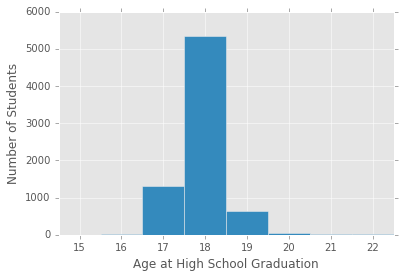

In [494]:
grads_age_at_graduation = get_student_age_from_graduation_dates(grads_dateofbirth, grads_dateofgraduation)

In [490]:
grads_age_at_graduation
labels, values = zip(*grads_age_at_graduation.items())
values = [x for y, x in sorted(zip(labels, values))]
labels = sorted(labels)
labels
values

Counter({15: 1, 16: 10, 17: 1324, 18: 5342, 19: 645, 20: 43, 21: 16, 22: 9})

[15, 16, 17, 18, 19, 20, 21, 22]

[1, 10, 1324, 5342, 645, 43, 16, 9]

In [486]:
zipped = zip([1, 2, 3], [4, 5, 6, 7]) # no error thrown when zipped objects are of different lengths
print([a+b for a,b in zipped])

[5, 7, 9]


In [453]:
student_num = 36427
grad_date = grads_dateofgraduation[3][student_num]
grad_date
dob = grads_dateofbirth[3][student_num]
dob
difference_in_years = relativedelta(grad_date, dob).years # how many years old is student at graduation
difference_in_years # this student is apparently 15 when graduated? 
# but this student had conflicting values in the data for their date of birth
get_student_field_from_districts(student_num, field_name)
# so from these conflicting values, 1996 seems a lot more likely than 1999, given that they graduated in 2014

Timestamp('2014-05-18 00:00:00')

Timestamp('1999-05-02 00:00:00')

15

Conflicting values for student 36427 in DATE_OF_BIRTH


{Timestamp('1996-05-02 00:00:00'), Timestamp('1999-05-02 00:00:00')}

<Container object of 14 artists>

<Container object of 14 artists>

(80, 100)

([<matplotlib.axis.XTick at 0x7ff2c828bf28>,
 <a list of 14 Text xticklabel objects>)

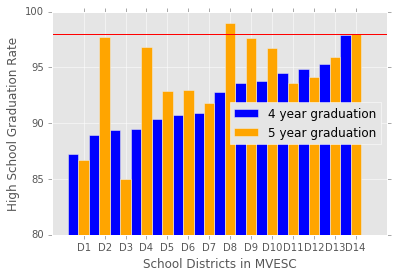

In [429]:
grad_4_year_rates = [94.9, 88.9, 89.5, 97.9, 95.3, 92.8, 87.2, 89.4, 90.9, 93.8, 94.5, 90.7, 93.6, 90.4]
grad_5_year_rates = [94.1, 97.7, 96.8, 98.0, 95.9, 99.0, 86.7, 85.0, 91.8, 96.7, 93.6, 93.0, 97.6, 92.9]
grad_5_year_rates = [x for y, x in sorted(zip(grad_4_year_rates, grad_5_year_rates))]
grad_4_year_rates.sort()

# arbitrary district codes, these don't match the ones in the data!
# fix district codes if reusing plot after deep dive presentation

ind = list(range(1,15))
shifted_ind = [i + width/2. for i in ind]
width = 1.0
district_codes = ["D" + str(i) for i in ind] 
plt.bar(ind, grad_4_year_rates, label = "4 year graduation", color = "blue", align = "center", width = width/2.)
plt.bar(shifted_ind, grad_5_year_rates, label = "5 year graduation", color = "orange", align = "center", width = width/2.)
plt.ylim(80, 100)
plt.xticks(shifted_ind, district_codes)
plt.xlabel("School Districts in MVESC")
plt.ylabel("High School Graduation Rate")
plt.legend(loc=5)
plt.axhline(y=98, hold=None, color="red")
plt.show()

In [420]:
[x for y, x in sorted(zip(grad_4_year_rates, grad_5_year_rates))]

[86.7,
 97.7,
 85.0,
 96.8,
 92.9,
 93.0,
 91.8,
 99.0,
 97.6,
 96.7,
 93.6,
 94.1,
 95.9,
 98.0]